In [19]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import joblib
import json
import matplotlib.pyplot as plt
from dataclasses import dataclass
import os

In [20]:
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [21]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define CNN Model for Regression
class CNNRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, out_dim=1):
        super(CNNRegressor, self).__init__()
        torch.manual_seed(42)  # For reproducibility
        self.mol_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        self.protein_conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        with torch.no_grad():
            dummy_mol = torch.zeros(1, 1, mol_input_dim)
            dummy_protein = torch.zeros(1, 1, protein_input_dim)
    
            mol_flatten_len = self.mol_conv(dummy_mol).view(1, -1).size(1)
            protein_flatten_len = self.protein_conv(dummy_protein).view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(mol_flatten_len + protein_flatten_len, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, out_dim)
        )

    def forward(self, mol_input, protein_input):
        # Reshape to (B, 1, L) for Conv1d
        mol_input = mol_input.unsqueeze(1)
        protein_input = protein_input.unsqueeze(1)

        mol_out = self.mol_conv(mol_input)
        protein_out = self.protein_conv(protein_input)

        # Flatten
        mol_out = mol_out.view(mol_out.size(0), -1)
        protein_out = protein_out.view(protein_out.size(0), -1)

        combined = torch.cat([mol_out, protein_out], dim=1)
        output = self.fc(combined).squeeze()
        return output


import torch.nn as nn
import torch
import torch.nn.functional as F

# Define MLP Model for Regression
class MLPRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, hidden_dim=1):
        super(MLPRegressor, self).__init__()
        torch.manual_seed(42)  # For reproducibility

        self.mol_encoder = nn.Linear(mol_input_dim, hidden_dim)
        self.protein_encoder = nn.Linear(protein_input_dim, hidden_dim)
        
        # norm layer + Dropout
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)

        # hidden layer + output layer
        self.hidden = nn.Linear(hidden_dim * 2, hidden_dim)
        self.regressor = nn.Linear(hidden_dim, 1)

        self.activation = nn.ReLU()

    def forward(self, mol_input, protein_input):
        # Reshape to (B, 1, L) for Conv1d
        mol_embedding = self.activation(self.mol_encoder(mol_input))
        protein_embedding = self.activation(self.protein_encoder(protein_input))

        # Concatenate + Normalize + Dropout
        combined = torch.cat((mol_embedding, protein_embedding), dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        # Hidden → Regress
        hidden_out = self.activation(self.hidden(combined))
        output = self.regressor(hidden_out)

        return output.squeeze(1)
    
    
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define Transformer for Regression
# https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch
class TransformerRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, d_model=128, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        torch.manual_seed(42)  # For reproducibility

        # Linear projection to embedding space
        self.mol_proj = nn.Linear(mol_input_dim, d_model)
        self.protein_proj = nn.Linear(protein_input_dim, d_model)

        # Positional encoding (learnable)
        self.pos_embedding = nn.Parameter(torch.randn(2, d_model))  # 2 positions: [mol, protein]

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, mol_input, protein_input):
        # Project input to embedding space
        mol_embed = self.mol_proj(mol_input).unsqueeze(1)       # shape: (B, 1, d_model)
        protein_embed = self.protein_proj(protein_input).unsqueeze(1)  # shape: (B, 1, d_model)
        torch.manual_seed(42)  # For reproducibility

        # Concatenate [mol, protein] tokens → sequence length = 2
        x = torch.cat([mol_embed, protein_embed], dim=1)  # shape: (B, 2, d_model)

        # Add learnable positional encoding
        x = x + self.pos_embedding.unsqueeze(0)  # broadcast (1, 2, d_model)

        # Pass through Transformer encoder
        encoded = self.transformer(x)  # shape: (B, 2, d_model)

        # Flatten both tokens
        flattened = encoded.view(encoded.size(0), -1)  # shape: (B, 2 * d_model)

        # Regression
        out = self.regressor(flattened)
        return out.view(-1)
    
    
import torch.nn as nn
import torch

# Define Diffusion Generative Model for Regression
class DiffusionGenerativeModel(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, hidden_dim, num_timesteps):
        super(DiffusionGenerativeModel, self).__init__()
        self.num_timesteps = num_timesteps
        self.mol_encoder = nn.Linear(mol_input_dim, hidden_dim)
        self.protein_encoder = nn.Linear(protein_input_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.denoise_model = nn.Linear(hidden_dim * 2, hidden_dim)
        self.regressor = nn.Linear(hidden_dim, 1)  # Regression layer
        self.activation = nn.ReLU()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Embedding for timesteps
        self.timestep_embedding = nn.Embedding(num_timesteps, hidden_dim * 2)
        self.noise_gen = torch.Generator(device=self.device).manual_seed(42)


    def forward(self, mol_features, protein_features, t):
        # Encode mol and protein features
        mol_embedding = self.activation(self.mol_encoder(mol_features))
        protein_embedding = self.activation(self.protein_encoder(protein_features))

        # Concatenate embeddings
        combined = torch.cat((mol_embedding, protein_embedding), dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        # Add learnable timestep embedding
        t_embedding = self.timestep_embedding(t.long())
        combined += t_embedding

        # Denoise process
        denoised = self.activation(self.denoise_model(combined))

        # Regression layer
        output = self.regressor(denoised)  # Predict continuous values
        return output

    def add_noise(self, x, noise_level=0.1, generator=None):
        """
        Add noise to input tensor with optional generator for reproducibility
        
        Args:
            x: Input tensor
            noise_level: Standard deviation of noise
            generator: Optional torch.Generator for reproducible noise
        """
        
        gen = self.noise_gen if generator is None else generator
        noise = noise_level * torch.randn(
            x.shape,                 # same shape as x
            generator=gen,           # input generator for reproducibility
            device=x.device,         # use the same device as x
            dtype=x.dtype            # keep the same data type
        )



        return x + noise


In [ ]:
@dataclass(init=True, repr=True, eq=False, order=False, unsafe_hash=False, frozen=False)
class ModelBenchmark:
    """
    A comprehensive benchmarking class for evaluating different machine learning models
    on enzyme kinetic datasets with various data splitting strategies.
    
    This class encapsulates the entire machine learning pipeline including data preprocessing,
    train/validation/test splitting, model initialization, training, and prediction.
    Supports multiple traditional ML algorithms and data splitting methods for robust evaluation.
    
    Attributes:
        data (pd.DataFrame | str): Input dataset as DataFrame or path to joblib file
        model_type (str): Type of model to use ["CAT","CNN","GBM","LR","MLP","RF","SVR","TRANS","XGB","Diffusion"]
        split_method (str): Data splitting strategy ('random', 'cold_mols', 'cold_proteins', 'load_from_file')
    
    Methods:
        __post_init: Post-initialization to load and validate input data, including setting seeds
        set_all_random_seed: Set random seeds for reproducibility
        rename_data_columns: Rename DataFrame columns using a mapping dictionary
        data_preprocessing: Preprocess features and labels for model training, including column renaming and feature concatenation
        split_data: Split dataset into train/validation/test sets
        model_init: Initialize the specified model type
        fit: Train the model on training data
        load_model_from_file: Load model from file
        save_model_to_file: Save model to file
        predict: Generate predictions using the trained model
        plot_train_history: Plot training history
        plot_pred_label_scatter_plot: Create a scatter plot of predictions vs true labels
        add_pred_to_data_with_pred_joblib: Add model predictions to the data_with_pred
        evaluate_predictions_with_given_label_and_pred: Evaluate predictions against true labels
        calculate_prediction_metrics: Static method to compute evaluation metrics
        save_or_add_metrics_to_file: Save or add evaluation metrics to a JSON file
    """
    data: pd.DataFrame | str
    model_type: str
    split_method: str


    '''
    def __init__(self, data, model_type, split_method, *args, **kwargs):
        """Initialize the BenchMarkModel with data, model type, and split method."""
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Data must be a pandas DataFrame.")
        self.data = data
        self.model_type = model_type
        self.split_method = split_method
        self.args = args
        self.kwargs = kwargs'''

    def __post_init__(self):
        """
        Post-initialization method to load and validate input data.
        
        Handles both DataFrame objects and file paths to joblib files.
        Ensures data integrity and proper format for downstream processing.
        
        Raises:
            ValueError: If data type is unsupported or file loading fails
        """
        # Debug information for data type checking
        print(f"Initial data type: {type(self.data)}")
        
        if isinstance(self.data, pd.DataFrame):
            print("Data is already a DataFrame")
            # Create a copy to avoid modifying original data
            self.data = self.data.copy()
        elif isinstance(self.data, str):
            print(f"Loading data from: {self.data}")
            try:
                # Load data from joblib file
                self.data = joblib.load(self.data)
                print(f"Data loaded successfully, type: {type(self.data)}")
            except Exception as e:
                print(f"Error loading data: {e}")
                raise ValueError(f"Could not load data from {self.data}: {e}")
        else:
            raise ValueError("Data must be a pandas DataFrame or a valid file path.")
        
        
        if self.split_method=="random_split":
            self.split_method = "random"
        elif self.split_method == "cold_molecules":
            self.split_method = "cold_mols"
        elif self.split_method not in ["random", "cold_mols", "cold_proteins", "load_index_from_file"]:
            raise ValueError(f"Unknown split method: {self.split_method}")
        
        if self.model_type not in ["CAT","CNN","GBM","LR","MLP","RF","SVR","TRANS","XGB","Diffusion"]:
            raise ValueError(f"Unknown model type: {self.model_type}")
        
        # Set random seeds for reproducibility
        self.set_all_random_seed(42)
    
    @staticmethod
    def set_all_random_seed(seed=42):
        """Set seeds for reproducibility"""
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print(f"Random seed set to: {seed}")
    
    def rename_data_columns(self, rename_dict):
        """
        Rename DataFrame columns using the provided mapping dictionary.
        
        Args:
            rename_dict (dict): Dictionary mapping old column names to new ones
            
        Returns:
            ModelBenchmark: Returns self for method chaining
        """
        self.data = self.data.rename(columns=rename_dict)
        return self

    def data_preprocessing(self, *args, **kwargs):
        """
        Preprocess the dataset by preparing features and labels for model training.
        
        This method handles column renaming, feature concatenation, and label extraction.
        Currently supports traditional ML models that require concatenated features.
        
        Args:
            *args: Variable length argument list
            **kwargs: Arbitrary keyword arguments including:
                rename_dict (dict, optional): Column renaming mapping
                
        Returns:
            ModelBenchmark: Returns self for method chaining
            
        Raises:
            ValueError: If required feature columns are missing
        """
        # Apply column renaming if specified
        if kwargs.get("rename_dict"):
            print(f"Data columns before renaming: {self.data.columns.tolist()}")
            self.rename_data_columns(kwargs["rename_dict"])
            print(f"Data columns after renaming: {self.data.columns.tolist()}")
        else:
            print(f"Data columns without renaming: {self.data.columns.tolist()}")

        # Validate required columns exist
        if ("metabolite_features" not in self.data.columns) or ("protein_features" not in self.data.columns):
            raise ValueError("Data is missing required feature columns or wrong column name.")
        
        # Process data for traditional ML models
        self.is_traditional_ml = self.model_type in ["CAT", "GBM", "LR", "RF", "SVR", "XGB"]
        self.X = np.array([np.concatenate([m, p]) for m, p in zip(self.data["metabolite_features"], self.data["protein_features"])])
        self.y = self.data["label"]

        
        '''
        if self.is_traditional_ml:
            # Concatenate metabolite and protein features into a single feature vector
            # This creates a flat feature representation suitable for traditional ML algorithms
            self.X = np.array([np.concatenate([m, p]) for m, p in zip(self.data["metabolite_features"], self.data["protein_features"])])
            self.y = self.data["label"]
        else:
            """TODO: Implement preprocessing for other model types"""
            pass'''
            
            
            
        
        return self

    def split_data(self, *args, **kwargs):
        """
        Split the dataset into training, validation, and test sets based on the specified method.
        
        Supports multiple splitting strategies:
        - Random split: Standard random partitioning (70% train, 15% val, 15% test)
        - Cold molecules: Split by unique molecules (to be implemented)
        - Cold proteins: Split by unique proteins (to be implemented)
        - Load from file: Use pre-computed split indices
        
        Args:
            *args: Variable length argument list
            **kwargs: Arbitrary keyword arguments including:
                save_index_path (str, optional): Path to save split indices
                index_file_path (str, required for load_index_from_file): Path to load pre-computed indices

        Returns:
            ModelBenchmark: Returns self for method chaining
            
        Raises:
            ValueError: If split method is unknown or indices don't match data length
        """
        # Generate train/validation/test indices based on split method
        if self.split_method == "random" or self.split_method == "random_split":
            # Standard random split: 70% train, 15% validation, 15% test
            self.train_index, self.temp_index = train_test_split(np.arange(len(self.data)),test_size=0.3, shuffle=True, random_state=42)
            self.val_index, self.test_index = train_test_split(self.temp_index, test_size=0.5, shuffle=True, random_state=42)

        elif self.split_method == "cold_mols":
            # TODO: Implement cold molecules split logic
            # This would split by unique molecules to test generalization to new compounds
            pass
        elif self.split_method == "cold_proteins":
            # TODO: Implement cold proteins split logic  
            # This would split by unique proteins to test generalization to new enzymes
            pass
        elif self.split_method == "load_index_from_file":
            # Load pre-computed split indices from JSON file
            if "index_file_path" not in kwargs:
                raise ValueError("index_file_path must be provided for load_index_from_file split method.")
            with open(kwargs["index_file_path"], "r") as f:
                indices = json.load(f)
                self.train_index = np.array(indices["train_index"])
                self.val_index = np.array(indices["val_index"])
                self.test_index = np.array(indices["test_index"])
                
            # Validate that indices cover all data points exactly once
            if len(self.train_index)+ len(self.val_index) + len(self.test_index) != len(self.data):
                raise ValueError("Indices from file do not match the length of the data.")   
            
        else:
            raise ValueError(f"Unknown split method: {self.split_method}")
        
        print("get split indices successfully")
        
        self.train_X = self.X[self.train_index]
        self.train_y = self.y[self.train_index]
        self.val_X = self.X[self.val_index]
        self.val_y = self.y[self.val_index]
        self.test_X = self.X[self.test_index]
        self.test_y = self.y[self.test_index]
                
        
        # Create feature and label subsets for each split
        self.train_df = self.data.loc[self.train_index,:]
        self.val_df = self.data.loc[self.val_index,:]
        self.test_df = self.data.loc[self.test_index,:]
        
        generator = torch.Generator()
        generator.manual_seed(42)
        self.train_dataset = MPI_Dataset(self.train_df)
        self.val_dataset = MPI_Dataset(self.val_df)
        self.test_dataset = MPI_Dataset(self.test_df)

        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True, generator=generator)
        self.val_loader = DataLoader(self.val_dataset, batch_size=32, shuffle=False)  
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False) 


        # Save split indices to file if specified
        if kwargs.get("save_index_path"):
            with open(kwargs["save_index_path"], "w") as f:
                json.dump({
                    "train_index": self.train_index.tolist(),
                    "val_index": self.val_index.tolist(),
                    "test_index": self.test_index.tolist()
                }, f)
            print(f"save split indices to {kwargs.get('save_index_path')}")
        return self
    
    def model_init(self, *args, **kwargs):
        """
        Initialize the specified machine learning model with given parameters.
        
        Supports various traditional ML algorithms including tree-based methods,
        linear models, and support vector machines.
        
        Args:
            *args: Variable length argument list passed to model constructor
            **kwargs: Arbitrary keyword arguments passed to model constructor
                optimizer (torch.optim.Optimizer, optional): Optimizer for training, only applicable for non-traditional ML models
                loss_function (torch.nn.Module, optional): Loss function for training, only applicable for non-traditional ML models
                num_timesteps (int, optional): Number of timesteps for diffusion models, only applicable for diffusion models
                hidden_dim (int, optional): Hidden dimension for MLP and CNN models
                random_state (int, optional): Random seed for reproducibility, only applicable for CAT, GBM, RF, XGB models
            
        Returns:
            ModelBenchmark: Returns self for method chaining
            
        Raises:
            ImportError: If required model library is not installed
        """
        print(f"Training {self.model_type}(traditional) model...")
        
        # Initialize model based on specified type
        if self.model_type == "CAT":
            # CatBoost Gradient Boosting
            import catboost as cat
            cat_kwargs = {"random_state": 42}
            cat_kwargs.update(kwargs)
            self.model = cat.CatBoostRegressor(*args, **cat_kwargs)
        elif self.model_type == "GBM":
            # Scikit-learn Gradient Boosting
            from sklearn.ensemble import GradientBoostingRegressor
            gbm_kwargs = {"random_state": 42}
            gbm_kwargs.update(kwargs)
            self.model = GradientBoostingRegressor(*args, **gbm_kwargs)
        elif self.model_type == "LR":
            # Linear Regression (no randomness)
            from sklearn.linear_model import LinearRegression
            self.model = LinearRegression(*args, **kwargs)
        elif self.model_type == "RF":
            # Random Forest with fixed random state for reproducibility
            from sklearn.ensemble import RandomForestRegressor
            rf_kwargs = {"random_state": 42}
            rf_kwargs.update(kwargs)
            self.model = RandomForestRegressor(*args, **rf_kwargs)
        elif self.model_type == "SVR":
            # Support Vector Regression (no randomness in most cases)
            from sklearn.svm import SVR
            self.model = SVR(*args, **kwargs)
        elif self.model_type == "XGB":
            # XGBoost Gradient Boosting
            import xgboost as xg
            xgb_kwargs = {"random_state": 42}
            xgb_kwargs.update(kwargs)
            self.model = xg.XGBRegressor(*args, **xgb_kwargs)
        else:
            # check gpu availability and set device
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print(f"Using device: {self.device}")
            
            # create train history DataFrame
            self.train_history = pd.DataFrame(columns=[  'epoch',
                'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR',
                'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
            
            # find the input dimension of metabolite and protein features dynamically
            for batch in self.train_loader:
                self.mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
                self.protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
                break
            
            
            # Initialize model based on type, using default parameters if not provided, overriding with kwargs
            if self.model_type == "CNN":
                default_kwargs = {"mol_input_dim": self.mol_input_dim, "protein_input_dim": self.protein_input_dim}
                default_kwargs.update(kwargs)
                self.model = CNNRegressor(*args, **default_kwargs)
            elif self.model_type == "MLP":
                default_kwargs = {"mol_input_dim": self.mol_input_dim, "protein_input_dim": self.protein_input_dim, "hidden_dim": 512}
                default_kwargs.update(kwargs)
                self.model = MLPRegressor(*args, **default_kwargs)
            elif self.model_type == "TRANS":
                default_kwargs = {"mol_input_dim": self.mol_input_dim, "protein_input_dim": self.protein_input_dim}
                default_kwargs.update(kwargs)
                self.model = TransformerRegressor(*args, **default_kwargs)
            elif self.model_type == "Diffusion":
                self.num_timesteps = kwargs.get("num_timesteps", 10)  # Default to 10 timesteps if not specified
                default_kwargs = {"mol_input_dim": self.mol_input_dim, "protein_input_dim": self.protein_input_dim, "hidden_dim": 512, "num_timesteps": 10}
                default_kwargs.update(kwargs)
                self.model = DiffusionGenerativeModel(*args, **default_kwargs)

            self.model = self.model.to(self.device)
            self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001) if kwargs.get("optimizer") is None else kwargs["optimizer"]
            self.criterion = nn.MSELoss() if kwargs.get("loss_function") is None else kwargs["loss_function"]

        # Split features (train_X) and labels (train_y)ized: {self.model_type} with args={args}, kwargs={kwargs}")
        return self

    def fit(self, *args, **kwargs):
        """
        Train the initialized model on the training dataset.
        
        Uses the preprocessed training features (train_X) and labels (train_y)
        to fit the model parameters.
        
        Args:
            *args: Variable length argument list passed to model.fit()
            **kwargs: Arbitrary keyword arguments passed to model.fit()
                epoch (int, optional): Number of training epochs, default is 2000
            
        Returns:
            ModelBenchmark: Returns self for method chaining
        """
        if not hasattr(self, 'model'):
            raise ValueError(f"Model is not initialized. Please call model_init() first. Or load a pre-trained model using load_model_from_file().")

        if self.is_traditional_ml:
            # Train the model using standard scikit-learn API
            self.model.fit(self.train_X, self.train_y, *args, **kwargs)
            print(f"Model {self.model_type} trained successfully.")
            return self
        else:
            from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
            from scipy.stats import pearsonr
            self.epoch = kwargs.get("epoch", 2000)
            for current_epoch in range(self.epoch):
                self.model.train()
                self.test_total_loss = 0.0
                self.val_total_loss = 0.0
                self.train_predictions, self.train_labels = [], []
            
                for batch in tqdm(self.train_loader, desc=f"Training Epoch {current_epoch + 1}"):
                    mol_features = batch['metabolite_features'].to(self.device)
                    protein_features = batch['protein_features'].to(self.device)
                    labels = batch['label'].to(self.device)

                    if self.model_type == "Diffusion":
                        # Add noise to features for diffusion model training
                        noisy_mol_features = self.model.add_noise(mol_features, noise_level=0.1)
                        noisy_protein_features = self.model.add_noise(protein_features, noise_level=0.1)
                    
                    
                    self.optimizer.zero_grad()
                    if self.model_type == "Diffusion":
                        outputs = self.model(noisy_mol_features, noisy_protein_features, torch.randint(0, self.num_timesteps, (mol_features.size(0),)).to(self.device)).squeeze()
                    else:
                        outputs = self.model(mol_features, protein_features)
                    loss = self.criterion(outputs, labels)
                    loss.backward()
                    self.optimizer.step()
                    self.test_total_loss += loss.item()

                    # Store predictions and labels for metrics
                    self.train_predictions.extend(outputs.detach().cpu().numpy())
                    self.train_labels.extend(labels.cpu().numpy())
                
                
                
                # Calculate training metrics
                self.train_predictions = np.array(self.train_predictions)
                self.train_labels = np.array(self.train_labels)
                train_metrics = self.evaluate_predictions_with_given_label_and_pred(self.train_labels, self.train_predictions)
                
                
                if current_epoch % 10 == 0:
                    print(f"Epoch {current_epoch} - Train Loss: {self.test_total_loss / len(self.train_loader):.4f}, Train MSE: {train_metrics['mse']:.4f}, Train MAE: {train_metrics['mae']:.4f}")

                # Validation
                self.model.eval()
                self.val_predictions, self.val_labels = [], []
                with torch.no_grad():
                    for batch in self.val_loader:
                        mol_features = batch['metabolite_features'].to(self.device)
                        protein_features = batch['protein_features'].to(self.device)
                        labels = batch['label'].to(self.device)

                        
                        if self.model_type == "Diffusion":
                        # Add noise to the features
                            noisy_mol_features = self.model.add_noise(mol_features, noise_level=0.1)
                            noisy_protein_features = self.model.add_noise(protein_features, noise_level=0.1)
                            outputs = self.model(noisy_mol_features, noisy_protein_features, torch.randint(0, self.num_timesteps, (mol_features.size(0),)).to(self.device)).squeeze()
                        else:
                            outputs = self.model(mol_features, protein_features)
                        self.val_predictions.extend(outputs.cpu().numpy())
                        self.val_labels.extend(labels.cpu().numpy())
                        val_loss = self.criterion(outputs, labels)
                        self.val_total_loss += val_loss.item()
                val_metrics = self.evaluate_predictions_with_given_label_and_pred(np.array(self.val_labels), np.array(self.val_predictions))
                
                

                if current_epoch % 10 == 0:
                    print(f"Epoch {current_epoch} - Validation Loss: {self.val_total_loss / len(self.val_loader):.4f}, Validation MSE: {val_metrics['mse']:.4f}, Validation MAE: {val_metrics['mae']:.4f}")

                # Save metrics to DataFrame
                new_row = {'epoch': current_epoch + 1, 'Train Loss': self.test_total_loss / len(self.train_loader), 'Train MSE': train_metrics['mse'], 'Train MAE': train_metrics['mae'], 'Train RMSE': train_metrics['rmse'], 'Train R2': train_metrics['r2'], 'Train Pearson': train_metrics['pearson_corr'], 'Train Median_AE': train_metrics['median_ae'], 'Train Explained_VAR': train_metrics['explained_var'], 
                        'Val Loss': self.val_total_loss / len(self.val_loader), 'Val MSE': val_metrics['mse'], 'Val MAE': val_metrics['mae'], 'Val RMSE': val_metrics['rmse'], 'Val R2': val_metrics['r2'], 'Val Pearson': val_metrics['pearson_corr'], 'Val Median_AE': val_metrics['median_ae'], 'Val Explained_VAR': val_metrics['explained_var']}
                self.train_history = pd.concat([self.train_history, pd.DataFrame([new_row])], ignore_index=True)

            pass
    
    def load_model_from_file(self, model_path, *args, **kwargs):
        """
        Load a pre-trained model from file.
        
        Args:
            model_path (str): Path to the saved model file
            
        Returns:
            ModelBenchmark: Returns self for method chaining
        """
        if self.is_traditional_ml:
            self.model = joblib.load(model_path)
            print(f"Model loaded from: {model_path}")
            return self
        else:
            """
            TODO: Implement model loading logic for other model types
            """
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))


            pass
    
    def save_model_to_file(self, model_path):
        """
        Save the trained model to file.
        
        Args:
            model_path (str): Path where to save the model
        """
        if hasattr(self, 'model'):
            # Save the model using joblib for traditional ML models
            if self.is_traditional_ml:
                joblib.dump(self.model, model_path)
                print(f"Model saved to: {model_path}")
            else:
                torch.save(self.model.state_dict(), model_path)
                torch.save(self.optimizer.state_dict(), model_path)
            print(f"Model {self.model_type} saved successfully to {model_path}")
            return self   
        else:
            raise ValueError("No model to save. Please train a model first.")

    def predict(self, df_or_X, *args, **kwargs):
        """
        Generate predictions using the trained model.
        
        Args:
            df (pd.DataFrame): DataFrame containing features for prediction
            
        Returns:
            numpy.ndarray: Model predictions
        """
        if isinstance(df_or_X, pd.DataFrame):
            if "metabolite_features" not in df_or_X.columns or "protein_features" not in df_or_X.columns:
                raise ValueError("DataFrame must contain 'metabolite_features' and 'protein_features' columns for prediction.")
        
        if self.is_traditional_ml:
            if isinstance(df_or_X, pd.DataFrame):
                X = np.array([np.concatenate([m, p]) for m, p in zip(df_or_X["metabolite_features"], df_or_X["protein_features"])])
            else:
                X = df_or_X
            
            if kwargs.get("use_tqdm"):
                # Use tqdm for progress bar if specified
                print("Generating predictions with progress bar...")
                return np.array([self.model.predict(x.reshape(1, -1)) for x in tqdm(X)])
            else:
                return self.model.predict(X)
        else:
            self.model.eval()
            test_predictions, test_labels = [], []
            if not isinstance(df_or_X, pd.DataFrame):
                raise ValueError("For non-traditional ML models, input must be a DataFrame.")
            
            test_dataset = MPI_Dataset(df_or_X)
            test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
            
            
            with torch.no_grad():
                for batch in tqdm(test_loader):
                    mol_features = batch['metabolite_features'].to(self.device)
                    protein_features = batch['protein_features'].to(self.device)
                    labels = batch['label'].to(self.device)
                    # print(f"mol_features device: {mol_features.device},\nprotein_features device: {protein_features.device},\nlabels device: {labels.device}")

                    if self.model_type == "Diffusion":
                        # Add noise to the features
                        noisy_mol_features = self.model.add_noise(mol_features, noise_level=0.1)
                        noisy_protein_features = self.model.add_noise(protein_features, noise_level=0.1)

                        outputs = self.model(noisy_mol_features, noisy_protein_features, torch.randint(0, self.num_timesteps, (mol_features.size(0),)).to(self.device)).squeeze()
                    else:
                        outputs = self.model(mol_features, protein_features)
                    test_predictions.extend(outputs.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
                    
            return np.array(test_predictions)

    def plot_train_history(self,selected_metrics1='Val MSE',selected_metrics2='Train MSE', *args, **kwargs):
        """        Plot the training history of the model.
        
        This method visualizes the training and validation loss, MSE, MAE, RMSE, R2, Pearson correlation,
        median absolute error, and explained variance over epochs."""
        if self.is_traditional_ml:
            raise ValueError("This method is only applicable for non-traditional ML models.")
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_history['epoch'], self.train_history[selected_metrics1], label=selected_metrics1, color='blue')
        plt.plot(self.train_history['epoch'], self.train_history[selected_metrics2], label=selected_metrics2, color='orange')
        plt.xlabel('Epoch')
        plt.ylabel(selected_metrics1+" and "+selected_metrics2)
        plt.title(f'{selected_metrics1+" and "+selected_metrics2} Over Epochs', fontsize=14)
        plt.grid(False)
        plt.legend()
        if kwargs.get("show_plot", True):
            plt.show()
        if kwargs.get("save_path"):
            plt.savefig(kwargs["save_path"], dpi=1200)
            print(f"Training history plot saved to {kwargs['save_path']}")

        
        
        

    def plot_pred_label_scatter_plot(self, *args, **kwargs):
        """
        Generate a scatter plot of model predictions vs true labels.
        
        This method visualizes the model's performance by plotting predicted values
        against actual labels, allowing for quick assessment of prediction quality.
        kwargs:
            save_path (str, optional): Path to save the scatter plot image
            show_plot (bool, optional): Whether to display the plot, default is True
        """


        plt.figure(figsize=(8, 6))
        plt.scatter(self.test_y, self.predict(self.test_df), alpha=0.5)
        plt.plot([self.test_y.min(), self.test_y.max()], [self.test_y.min(), self.test_y.max()], linestyle="--", color="red", lw=2)
        plt.ylabel("predicted")
        plt.xlabel("label")
        plt.title(f"{self.model_type} Model Predictions vs Label")
        plt.tight_layout()
        if kwargs.get("save_path"):
            plt.savefig(kwargs["save_path"])
            print(f"Scatter plot saved to {kwargs['save_path']}")
        if kwargs.get("show_plot", True):
            print("Displaying scatter plot of predictions vs labels...")
            plt.show()
        
    def add_pred_to_data_with_pred_joblib(self, data_with_pred_path, *args, **kwargs):
        """
        Add model predictions to the original DataFrame and save to file.
        Args:
            data_with_pred_path (str): Path to save the DataFrame with predictions
            *args: Variable length argument list
            **kwargs: Arbitrary keyword arguments including:
                force_overwrite (bool, optional): Whether to overwrite existing predictions
        """
        predictions = self.predict(self.data, use_tqdm=kwargs.get("use_tqdm", False))
        pred_column_name = f"{self.model_type}_pred"
        
        # Load existing data or create new one
        if os.path.exists(data_with_pred_path):
            data_with_pred = joblib.load(data_with_pred_path)
            
            # Check if predictions already exist
            if pred_column_name in data_with_pred.columns:
                if not kwargs.get("force_overwrite", False):
                    raise ValueError(f"Predictions already exist in {data_with_pred_path}. "
                                   f"Set force_overwrite=True to overwrite.")
                print(f"Overwriting existing predictions in {data_with_pred_path}.")
        else:
            # Create new DataFrame from original data
            data_with_pred = self.data.copy()
        
        # Add predictions and save
        data_with_pred[pred_column_name] = predictions
        joblib.dump(data_with_pred, data_with_pred_path)
        print(f"Predictions saved to {data_with_pred_path}")
        
        return self
    
    @staticmethod
    def evaluate_predictions_with_given_label_and_pred(label, pred):
        """
        Evaluate model predictions against true labels using various metrics.
        Args:
            label (numpy.ndarray): True labels
            pred (numpy.ndarray): Model predictions
            Returns:
            dict: Dictionary containing evaluation metrics"""
        
        
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score
        from scipy.stats import pearsonr

        mse = mean_squared_error(label, pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(label, pred)
        r2 = r2_score(label, pred)
        pearson_corr, _ = pearsonr(label, pred)
        median_ae = median_absolute_error(label, pred)
        explained_var = explained_variance_score(label, pred)

        return {
            "mse": mse,
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
            "pearson_corr": pearson_corr,
            "median_ae": median_ae,
            "explained_var": explained_var
        }

    def calculate_prediction_metrics(self):
        """
        Evaluate the model's performance using general prediction metrics.
        """
        self.test_metrics = self.evaluate_predictions_with_given_label_and_pred(self.test_y, self.predict(self.test_df))
        self.val_metrics = self.evaluate_predictions_with_given_label_and_pred(self.val_y, self.predict(self.val_df))
        self.train_metrics = self.evaluate_predictions_with_given_label_and_pred(self.train_y, self.predict(self.train_df))
        self.total_metrics = pd.DataFrame({
            "Train": self.train_metrics,
            "Validation": self.val_metrics,
            "Test": self.test_metrics
        }).T
        self.total_metrics["Model"] = self.model_type
        self.total_metrics["Dataset"] = ['Train','Validation','Test']
        self.total_metrics["Dataspliting Mode"] = self.split_method
        return self

    def save_or_add_metrics_to_file(self, file_path, create_new_file=False, force_overwrite=False):
        
        
        
        # Handle new file creation
        if create_new_file:
            self.total_metrics.to_csv(file_path, mode='w', header=True, index=False)
            print(f"Metrics saved to {file_path}")
            return self
        
        # Handle existing file operations
        if not os.path.exists(file_path):
            raise ValueError(f"File {file_path} does not exist. Please create it first or set is_new_file=True.")
        
        # Check for existing metrics
        exist_metrics = pd.read_csv(file_path)
        condition = (exist_metrics["Model"] == self.model_type) & (exist_metrics["Dataspliting Mode"] == self.split_method)
        
        if len(exist_metrics.loc[condition]) > 0:
            if not force_overwrite:
                raise ValueError(f"Metrics for model {self.model_type} with split method {self.split_method} already exist in {file_path}.\n"
                               f"Please choose a different file or set force_overwrite=True to overwrite.")
            print(f"Overwriting existing metrics for model {self.model_type} with split method {self.split_method} in {file_path}.")
        
        # Append metrics to existing file
        self.total_metrics.to_csv(file_path, mode='a', header=False, index=False)
        print(f"Metrics saved to {file_path}")
        return self

In [ ]:
# Initialize the ModelBenchmark with enzyme kinetic data, Linear Regression model, and random split
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="LR",
                                   split_method="random",)

# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

# Execute the complete ML pipeline: split data, initialize model, and train
bench_mark_model.split_data().model_init().load_model_from_file("./../../A03_models/random_split/LR model_Catpred.joblib")
# bench_mark_model.split_data().model_init().fit()

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib
Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>
Data columns before renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'log10kcat_max', 'metabolite_features', 'protein_features']
Data columns after renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'label', 'metabolite_features', 'protein_features']
get split indices successfully
Training LR(traditional) model...
Model initialized: LR with args=(), kwargs={}
Model loaded from: ./../../A03_models/random_split/LR model_Catpred.joblib


ModelBenchmark(data=                                                Sequence sequence_source  \
0      MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...           sabio   
1      MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...          brenda   
2      MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...          brenda   
3      MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...          brenda   
4      MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...           sabio   
...                                                  ...             ...   
23146  MTVFSAIPPISCWFTGRTPASWDKTMDMQTSFLDRLFEEGLLIETG...           sabio   
23147  MYRSGERLLGSHALPAEQRDFLPLETTNNNNNHHQPGAWARRAGSS...          brenda   
23148  MALRACGLIIFRRCLIPKVDNNAIEFLLLQASDGIHHWTPPKGHVE...           sabio   
23149  MTTAPTPSIFEPARLGPLTLRNRIVKAATFEGVMPRGAVSDDLINF...  uniprot_search   
23150  MLKVISSLLFYMTASLMAVASPLAHSGESRGEYPTVSEIPVGEVRL...          brenda   

          uniprot                                             Smile

In [53]:
# Generate predictions on the entire feature set
bench_mark_model.predict(bench_mark_model.X)

array([ 2.2598267 , -0.06915283, -0.0513916 , ..., -0.26843262,
        0.8468933 ,  1.2799988 ], dtype=float32)

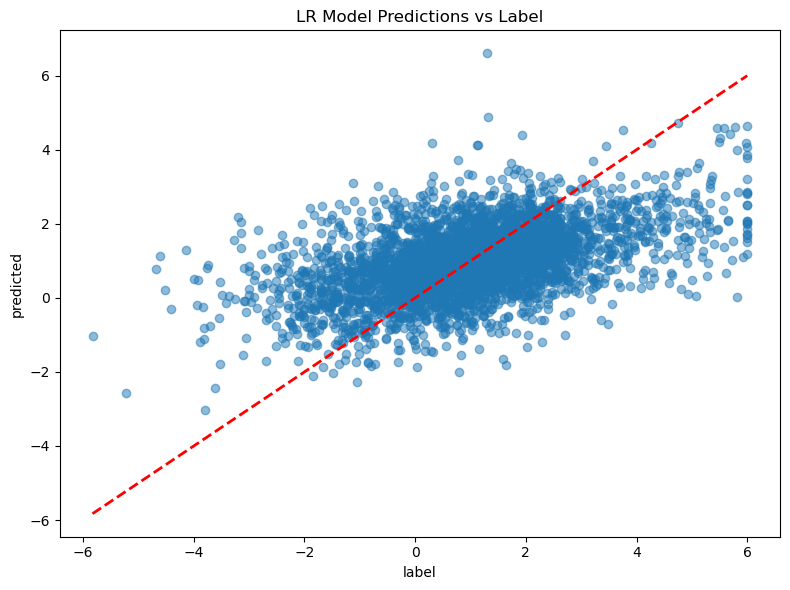

In [ ]:
# bench_mark_model.add_pred_to_data_with_pred("./../../A04_result_plot/kcat_with_pred.joblib")
bench_mark_model.plot_pred_label_scatter_plot()

In [55]:
bench_mark_model.calculate_prediction_metrics().save_or_add_metrics_to_file("./../../A04_result_plot/model performance metrics_analysis.csv", create_new_file=True)
bench_mark_model.total_metrics

Metrics saved to ./../../A04_result_plot/model performance metrics_analysis.csv


,mse,rmse,mae,r2,pearson_corr,median_ae,explained_var,Model,Dataset,Dataspliting Mode
Train,1.857997,1.363083,1.043234,0.337878,0.581274,0.821704,0.337880,LR,Train,random
Validation,2.111555,1.453119,1.117247,0.204111,0.472117,0.882108,0.204155,LR,Validation,random
Test,2.142717,1.463802,1.128122,0.237907,0.495490,0.902721,0.237907,LR,Test,random


CAT

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib
Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>
Data columns before renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'log10kcat_max', 'metabolite_features', 'protein_features']
Data columns after renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'label', 'metabolite_features', 'protein_features']
get split indices successfully
Training CAT(traditional) model...
Model initialized: CAT with args=(), kwargs={}
Learning rate set to 0.063578
0:	learn: 1.6659624	total: 230ms	remaining: 3m 49s
1:	learn: 1.6576100	total: 269ms	remaining: 2m 14s
2:	learn: 1.6508854	total: 309ms	remaining: 1m 42s
3:	learn: 1.6431820	total: 348ms	remaining: 1m 26s
4:	learn: 1.6355370	total: 389ms	remaining: 1m 17s
5:	learn: 1.6284553	tot

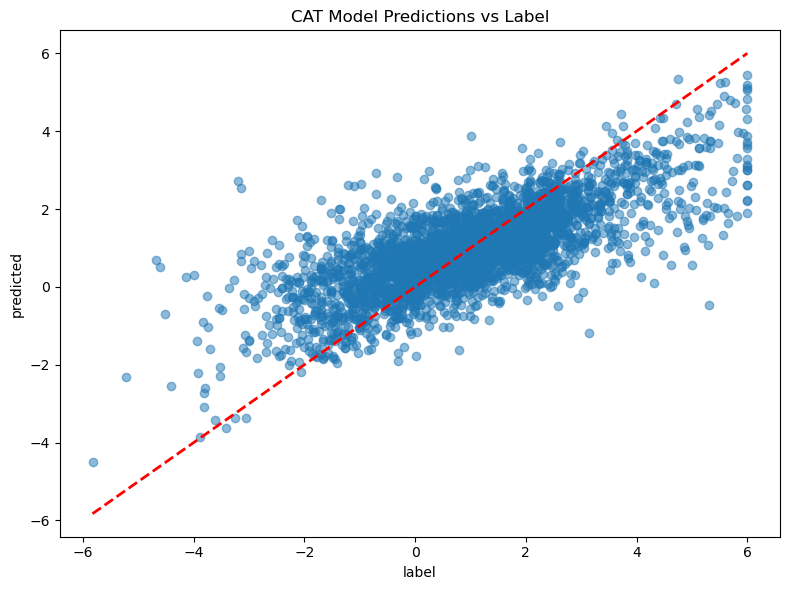

Metrics saved to ./../../A04_result_plot/model performance metrics_analysis.csv


,mse,rmse,mae,r2,pearson_corr,median_ae,explained_var,Model,Dataset,Dataspliting Mode
Train,0.597577,0.773031,0.580377,0.787046,0.905078,0.446648,0.787046,CAT,Train,random
Validation,1.325453,1.151283,0.859815,0.500409,0.712936,0.654283,0.500472,CAT,Validation,random
Test,1.331696,1.153991,0.857846,0.526360,0.731135,0.657464,0.526390,CAT,Test,random


In [ ]:
# Initialize the ModelBenchmark with enzyme kinetic data, CAT model, and random split
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="CAT",
                                   split_method="random",)

# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

# Execute the complete ML pipeline: split data, initialize model, and train
bench_mark_model.split_data().model_init().fit()

bench_mark_model.add_pred_to_data_with_pred_joblib("./../../A04_result_plot/kcat_with_pred.joblib")
# bench_mark_model.add_pred_to_data_with_pred("./../../A01_dataset/kcat_with_pred.joblib")
bench_mark_model.plot_pred_label_scatter_plot()
bench_mark_model.calculate_prediction_metrics().save_or_add_metrics_to_file("./../../A04_result_plot/model performance metrics_analysis.csv")
bench_mark_model.total_metrics

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib
Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>
Data columns before renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'log10kcat_max', 'metabolite_features', 'protein_features']
Data columns after renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'label', 'metabolite_features', 'protein_features']
get split indices successfully
Training GBM(traditional) model...
Model initialized: GBM with args=(), kwargs={}
Model loaded from: ./../../A03_models/random_split/GBM model_Catpred.joblib
Overwriting existing predictions in ./../../A04_result_plot/kcat_with_pred.joblib.
Predictions saved to ./../../A04_result_plot/kcat_with_pred.joblib


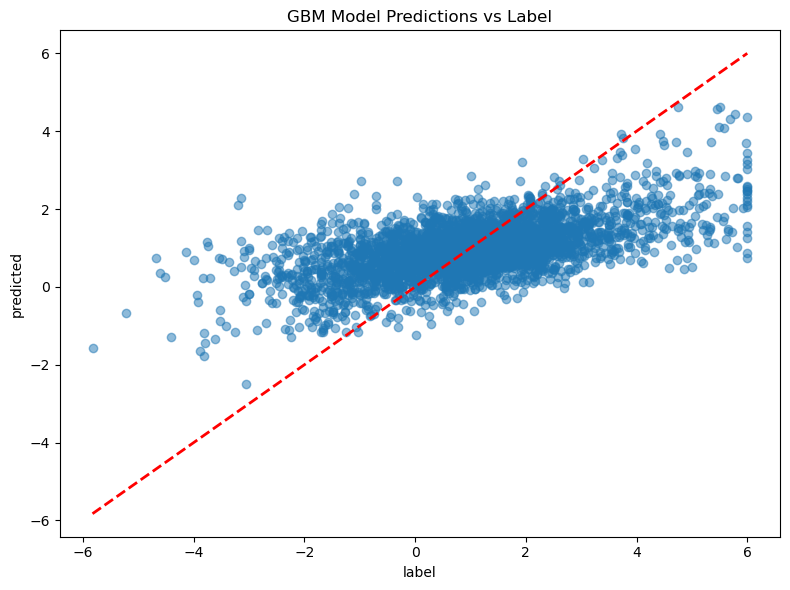

Overwriting existing metrics for model GBM with split method random in ./../../A04_result_plot/model performance metrics_analysis.csv.
Metrics saved to ./../../A04_result_plot/model performance metrics_analysis.csv


,mse,rmse,mae,r2,pearson_corr,median_ae,explained_var,Model,Dataset,Dataspliting Mode
Train,1.760468,1.326826,1.006635,0.372634,0.651905,0.783278,0.372634,GBM,Train,random
Validation,1.889341,1.374533,1.054967,0.287868,0.557619,0.824593,0.287933,GBM,Validation,random
Test,1.903683,1.379740,1.059815,0.322923,0.595107,0.838253,0.323082,GBM,Test,random


In [ ]:
# Initialize the ModelBenchmark with enzyme kinetic data, GBM model, and random split
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="GBM",
                                   split_method="random",)

# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

# Execute the complete ML pipeline: split data, initialize model, and train
# bench_mark_model.split_data().model_init().fit()
bench_mark_model.split_data().model_init().load_model_from_file("./../../A03_models/random_split/GBM model_Catpred.joblib")

bench_mark_model.add_pred_to_data_with_pred_joblib("./../../A04_result_plot/kcat_with_pred.joblib")
# bench_mark_model.add_pred_to_data_with_pred("./../../A01_dataset/kcat_with_pred.joblib")
bench_mark_model.plot_pred_label_scatter_plot()
bench_mark_model.calculate_prediction_metrics().save_or_add_metrics_to_file("./../../A04_result_plot/model performance metrics_analysis.csv")
bench_mark_model.total_metrics

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib
Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>
Data columns before renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'log10kcat_max', 'metabolite_features', 'protein_features']
Data columns after renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'label', 'metabolite_features', 'protein_features']
get split indices successfully
Training RF(traditional) model...
Model initialized: RF with args=(), kwargs={}
Model loaded from: ./../../A03_models/random_split/RF model_Catpred.joblib
Predictions saved to ./../../A04_result_plot/kcat_with_pred.joblib


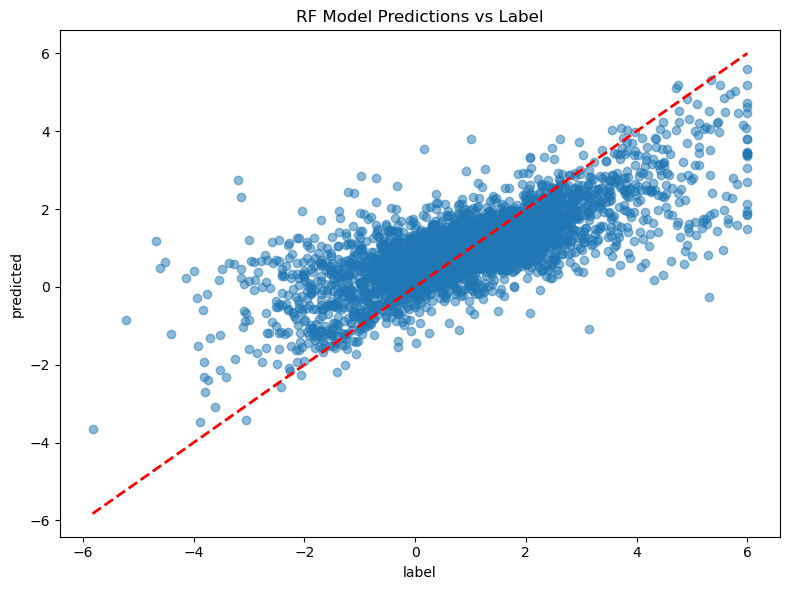

Metrics saved to ./../../A04_result_plot/model performance metrics_analysis.csv


,mse,rmse,mae,r2,pearson_corr,median_ae,explained_var,Model,Dataset,Dataspliting Mode
Train,0.192541,0.438794,0.313393,0.931386,0.980764,0.221194,0.931386,RF,Train,random
Validation,1.320439,1.149104,0.840365,0.502299,0.721490,0.613771,0.502374,RF,Validation,random
Test,1.307085,1.143278,0.824449,0.535113,0.745890,0.596356,0.535134,RF,Test,random


In [67]:
# Initialize the ModelBenchmark with enzyme kinetic data, RF model, and random split
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="RF",
                                   split_method="random",)

# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

# Execute the complete ML pipeline: split data, initialize model, and train
# bench_mark_model.split_data().model_init().fit()
bench_mark_model.split_data().model_init().load_model_from_file("./../../A03_models/random_split/RF model_Catpred.joblib")

bench_mark_model.add_pred_to_data_with_pred_joblib("./../../A04_result_plot/kcat_with_pred.joblib")
# bench_mark_model.add_pred_to_data_with_pred("./../../A01_dataset/kcat_with_pred.joblib")
bench_mark_model.plot_pred_label_scatter_plot()
bench_mark_model.calculate_prediction_metrics().save_or_add_metrics_to_file("./../../A04_result_plot/model performance metrics_analysis.csv")
bench_mark_model.total_metrics

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib
Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>
Data columns before renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'log10kcat_max', 'metabolite_features', 'protein_features']
Data columns after renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'label', 'metabolite_features', 'protein_features']
get split indices successfully
Training SVR(traditional) model...
Model initialized: SVR with args=(), kwargs={}
Model loaded from: ./../../A03_models/random_split/SVR model_Catpred.joblib
Generating predictions with progress bar...


100%|██████████| 23151/23151 [03:12<00:00, 120.21it/s]


Overwriting existing predictions in ./../../A04_result_plot/kcat_with_pred.joblib.
Predictions saved to ./../../A04_result_plot/kcat_with_pred.joblib


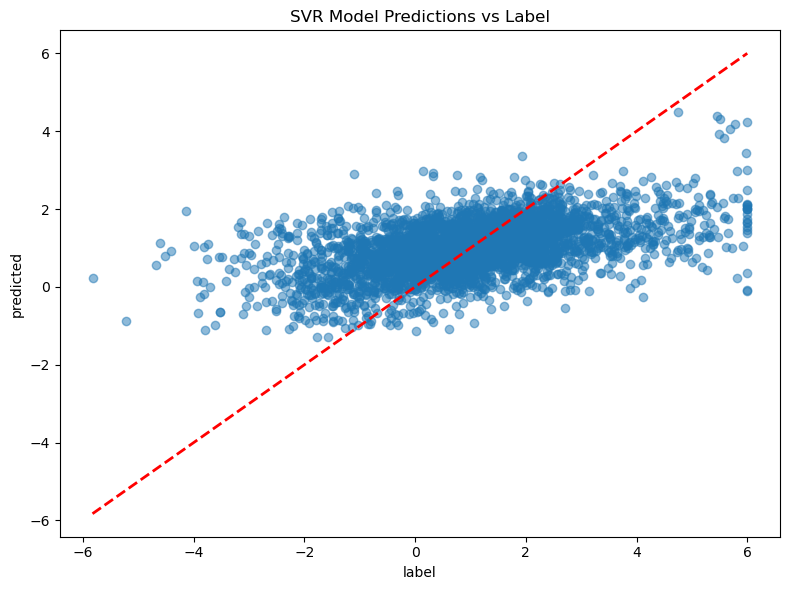

Metrics saved to ./../../A04_result_plot/model performance metrics_analysis.csv


,mse,rmse,mae,r2,pearson_corr,median_ae,explained_var,Model,Dataset,Dataspliting Mode
Train,2.098714,1.448694,1.067760,0.252096,0.515338,0.795787,0.252255,SVR,Train,random
Validation,2.087556,1.444838,1.094071,0.213157,0.466872,0.831519,0.213720,SVR,Validation,random
Test,2.149107,1.465983,1.104617,0.235634,0.492962,0.839990,0.235640,SVR,Test,random


In [5]:
# Initialize the ModelBenchmark with enzyme kinetic data, SVR model, and random split
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="SVR",
                                   split_method="random",)

# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

# Execute the complete ML pipeline: split data, initialize model, and train
# bench_mark_model.split_data().model_init().fit()
bench_mark_model.split_data().model_init().load_model_from_file("./../../A03_models/random_split/SVR model_Catpred.joblib")

bench_mark_model.add_pred_to_data_with_pred_joblib("./../../A04_result_plot/kcat_with_pred.joblib",use_tqdm=True, force_overwrite=True)
# bench_mark_model.add_pred_to_data_with_pred("./../../A01_dataset/kcat_with_pred.joblib")
bench_mark_model.plot_pred_label_scatter_plot()
bench_mark_model.calculate_prediction_metrics().save_or_add_metrics_to_file("./../../A04_result_plot/model performance metrics_analysis.csv")
bench_mark_model.total_metrics

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib
Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>
Data columns before renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'log10kcat_max', 'metabolite_features', 'protein_features']
Data columns after renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'label', 'metabolite_features', 'protein_features']
get split indices successfully
Training XGB(traditional) model...
Model initialized: XGB with args=(), kwargs={}
Model loaded from: ./../../A03_models/random_split/XGBoost model_Catpred.joblib


c:\Users\youbowei0126\.conda\envs\conda_venv_2\Lib\pickle.py:1760: UserWarning: [22:42:31] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\gbm\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


Predictions saved to ./../../A04_result_plot/kcat_with_pred.joblib


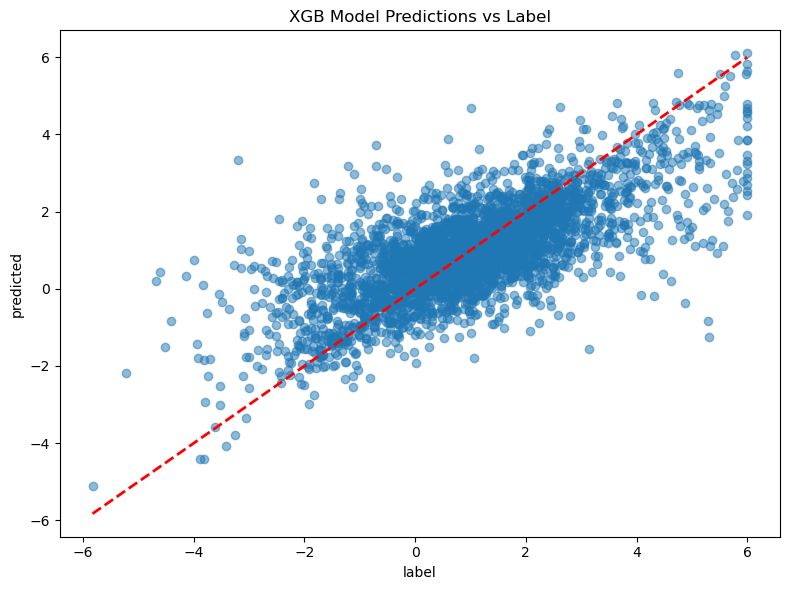

Metrics saved to ./../../A04_result_plot/model performance metrics_analysis.csv


,mse,rmse,mae,r2,pearson_corr,median_ae,explained_var,Model,Dataset,Dataspliting Mode
Train,0.267627,0.517327,0.387271,0.904628,0.956735,0.299095,0.904628,XGB,Train,random
Validation,1.400462,1.183411,0.875395,0.472137,0.687932,0.632643,0.472150,XGB,Validation,random
Test,1.381763,1.175484,0.858685,0.508553,0.713531,0.631328,0.508688,XGB,Test,random


In [8]:
# Initialize the ModelBenchmark with enzyme kinetic data, XGB model, and random split
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="XGB",
                                   split_method="random",)

# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

# Execute the complete ML pipeline: split data, initialize model, and train
# bench_mark_model.split_data().model_init().fit()
bench_mark_model.split_data().model_init().load_model_from_file("./../../A03_models/random_split/XGBoost model_Catpred.joblib")

bench_mark_model.add_pred_to_data_with_pred_joblib("./../../A04_result_plot/kcat_with_pred.joblib")
# bench_mark_model.add_pred_to_data_with_pred("./../../A01_dataset/kcat_with_pred.joblib")
bench_mark_model.plot_pred_label_scatter_plot()
bench_mark_model.calculate_prediction_metrics().save_or_add_metrics_to_file("./../../A04_result_plot/model performance metrics_analysis.csv")
bench_mark_model.total_metrics

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib
Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>
Random seed set to: 42
Data columns before renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'log10kcat_max', 'metabolite_features', 'protein_features']
Data columns after renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'label', 'metabolite_features', 'protein_features']
get split indices successfully
Training CNN(traditional) model...
Using device: cuda


C:\Users\youbowei0126\AppData\Local\Temp\ipykernel_12200\822697095.py:477: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, ma

Overwriting existing predictions in ./../../A04_result_plot/kcat_with_pred.joblib.
Predictions saved to ./../../A04_result_plot/kcat_with_pred.joblib
Displaying scatter plot of predictions vs labels...


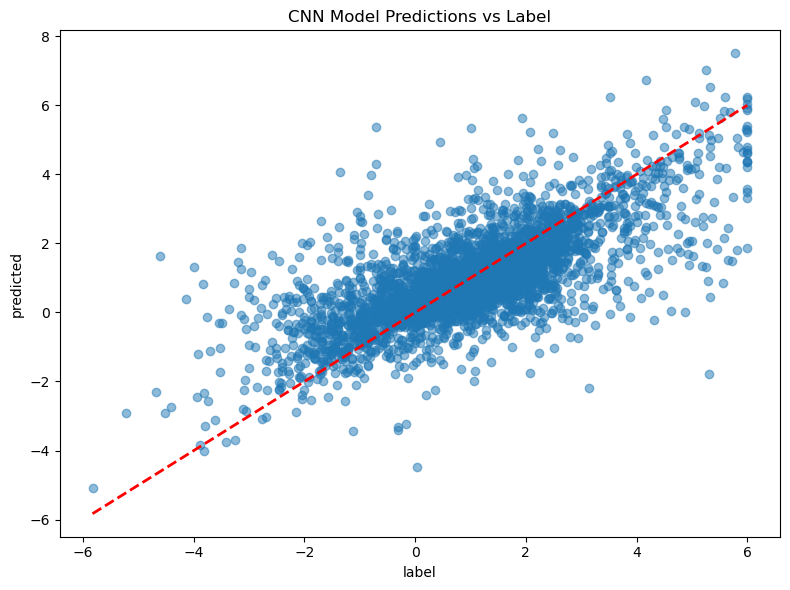

Metrics saved to ./../../A04_result_plot/model performance metrics_analysis.csv


,mse,rmse,mae,r2,pearson_corr,median_ae,explained_var,Model,Dataset,Dataspliting Mode
Train,0.101645,0.318818,0.226758,0.963778,0.985833,0.171235,0.964279,CNN,Train,random
Validation,1.406605,1.186004,0.857396,0.469821,0.692244,0.611320,0.469912,CNN,Validation,random
Test,1.390509,1.179199,0.833254,0.505442,0.718050,0.576296,0.505442,CNN,Test,random


In [13]:
# Initialize the ModelBenchmark with enzyme kinetic data, CNN model, and random split
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="CNN",
                                   split_method="random",)

# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

# Execute the complete ML pipeline: split data, initialize model, and train
# bench_mark_model.split_data().model_init().fit()
bench_mark_model.split_data()
bench_mark_model.model_init()
bench_mark_model.load_model_from_file("./../../A03_models/random_split/CNN model_Catpred.pt")

bench_mark_model.add_pred_to_data_with_pred_joblib("./../../A04_result_plot/kcat_with_pred.joblib",force_overwrite =True)
# bench_mark_model.add_pred_to_data_with_pred("./../../A01_dataset/kcat_with_pred.joblib")
bench_mark_model.plot_pred_label_scatter_plot()
bench_mark_model.calculate_prediction_metrics().save_or_add_metrics_to_file("./../../A04_result_plot/model performance metrics_analysis.csv")
bench_mark_model.total_metrics

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib
Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>
Random seed set to: 42
Data columns before renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'log10kcat_max', 'metabolite_features', 'protein_features']
Data columns after renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'label', 'metabolite_features', 'protein_features']
get split indices successfully
Training MLP(traditional) model...
Using device: cuda


C:\Users\youbowei0126\AppData\Local\Temp\ipykernel_12200\822697095.py:477: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, ma

Overwriting existing predictions in ./../../A04_result_plot/kcat_with_pred.joblib.
Predictions saved to ./../../A04_result_plot/kcat_with_pred.joblib
Displaying scatter plot of predictions vs labels...


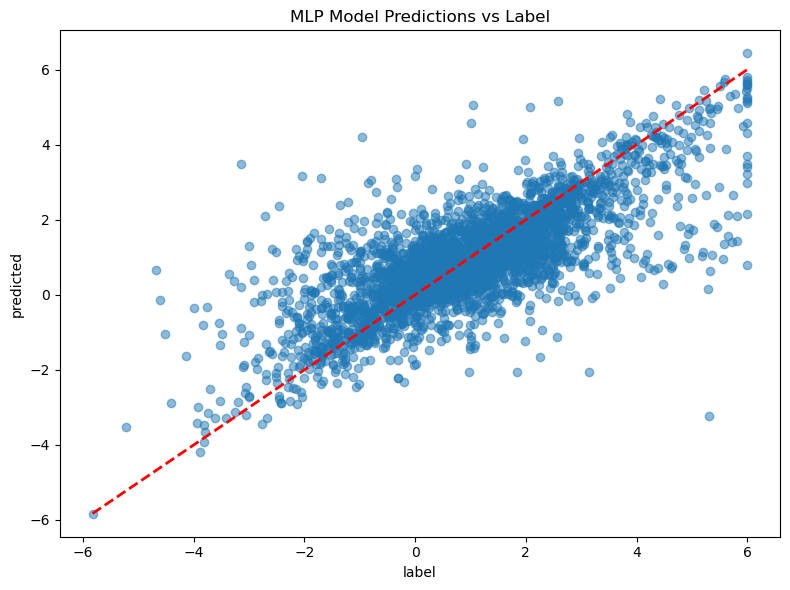

Overwriting existing metrics for model MLP with split method random in ./../../A04_result_plot/model performance metrics_analysis.csv.
Metrics saved to ./../../A04_result_plot/model performance metrics_analysis.csv


,mse,rmse,mae,r2,pearson_corr,median_ae,explained_var,Model,Dataset,Dataspliting Mode
Train,0.034341,0.185313,0.131763,0.987762,0.994367,0.101418,0.988666,MLP,Train,random
Validation,1.243568,1.115154,0.782972,0.531273,0.731077,0.538501,0.531932,MLP,Validation,random
Test,1.201994,1.096355,0.753970,0.572491,0.757874,0.500722,0.572845,MLP,Test,random


In [17]:
# Initialize the ModelBenchmark with enzyme kinetic data, MLP model, and random split
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="MLP",
                                   split_method="random",)

# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

# Execute the complete ML pipeline: split data, initialize model, and train
# bench_mark_model.split_data().model_init().fit()
bench_mark_model.split_data()
bench_mark_model.model_init()
bench_mark_model.load_model_from_file("./../../A03_models/random_split/MLP model_Catpred.pt")

bench_mark_model.add_pred_to_data_with_pred_joblib("./../../A04_result_plot/kcat_with_pred.joblib", force_overwrite=True)
# bench_mark_model.add_pred_to_data_with_pred("./../../A01_dataset/kcat_with_pred.joblib")
bench_mark_model.plot_pred_label_scatter_plot()
bench_mark_model.calculate_prediction_metrics().save_or_add_metrics_to_file("./../../A04_result_plot/model performance metrics_analysis.csv", force_overwrite=True)
bench_mark_model.total_metrics

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib
Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>
Random seed set to: 42
Data columns before renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'log10kcat_max', 'metabolite_features', 'protein_features']
Data columns after renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'label', 'metabolite_features', 'protein_features']
get split indices successfully
Training TRANS(traditional) model...
Using device: cuda


C:\Users\youbowei0126\AppData\Local\Temp\ipykernel_12200\3337171582.py:477: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, m

Predictions saved to ./../../A04_result_plot/kcat_with_pred.joblib
Displaying scatter plot of predictions vs labels...


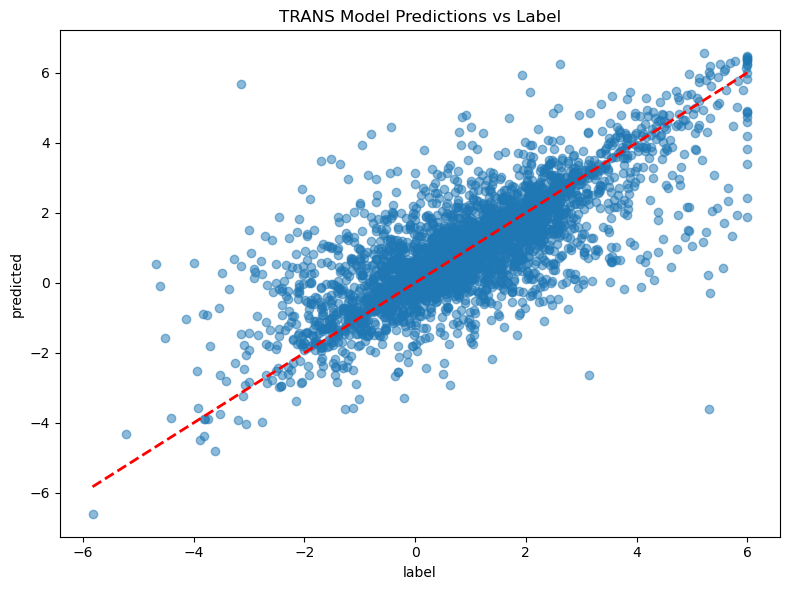

Metrics saved to ./../../A04_result_plot/model performance metrics_analysis.csv


,mse,rmse,mae,r2,pearson_corr,median_ae,explained_var,Model,Dataset,Dataspliting Mode
Train,0.062470,0.249941,0.163443,0.977738,0.991596,0.112001,0.977761,TRANS,Train,random
Validation,1.383661,1.176291,0.812479,0.478469,0.716264,0.517150,0.478577,TRANS,Validation,random
Test,1.319849,1.148847,0.773406,0.530574,0.749970,0.493151,0.530923,TRANS,Test,random


In [21]:
# Initialize the ModelBenchmark with enzyme kinetic data, TRANS model, and random split
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="TRANS",
                                   split_method="random",)

# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

# Execute the complete ML pipeline: split data, initialize model, and train
# bench_mark_model.split_data().model_init().fit()
bench_mark_model.split_data()
bench_mark_model.model_init()
bench_mark_model.load_model_from_file("./../../A03_models/random_split/Transformer model_Catpred.pt")

bench_mark_model.add_pred_to_data_with_pred_joblib("./../../A04_result_plot/kcat_with_pred.joblib")
# bench_mark_model.add_pred_to_data_with_pred("./../../A01_dataset/kcat_with_pred.joblib")
bench_mark_model.plot_pred_label_scatter_plot()
bench_mark_model.calculate_prediction_metrics().save_or_add_metrics_to_file("./../../A04_result_plot/model performance metrics_analysis.csv")
bench_mark_model.total_metrics

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib


C:\Users\youbowei0126\AppData\Local\Temp\ipykernel_21984\3750260948.py:477: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, m

Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>
Random seed set to: 42
Data columns before renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'log10kcat_max', 'metabolite_features', 'protein_features']
Data columns after renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'label', 'metabolite_features', 'protein_features']
get split indices successfully
Training Diffusion(traditional) model...
Using device: cuda


100%|██████████| 724/724 [00:01<00:00, 390.72it/s]


Overwriting existing predictions in ./../../A04_result_plot/kcat_with_pred.joblib.
Predictions saved to ./../../A04_result_plot/kcat_with_pred.joblib


100%|██████████| 109/109 [00:00<00:00, 469.83it/s]


Displaying scatter plot of predictions vs labels...


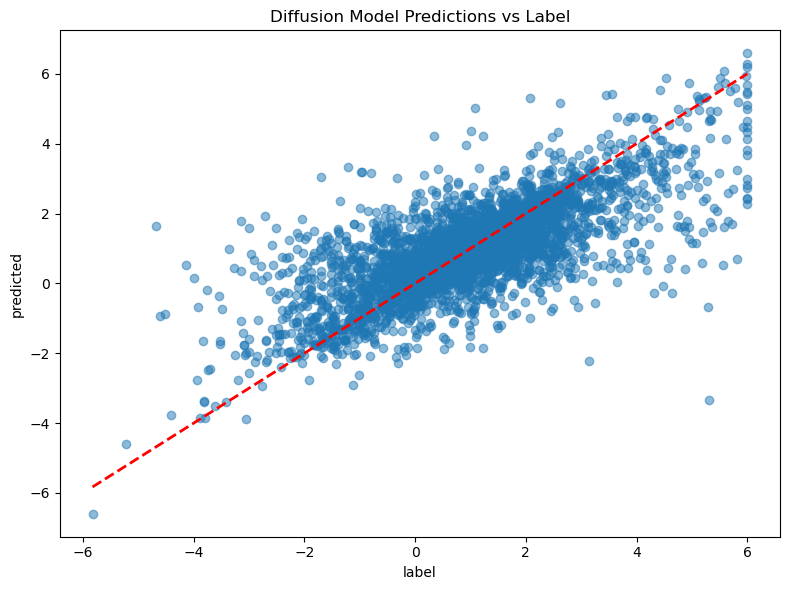

100%|██████████| 507/507 [00:01<00:00, 470.32it/s]

Overwriting existing metrics for model Diffusion with split method random in ./../../A04_result_plot/model performance metrics_analysis.csv.
Metrics saved to ./../../A04_result_plot/model performance metrics_analysis.csv


,mse,rmse,mae,r2,pearson_corr,median_ae,explained_var,Model,Dataset,Dataspliting Mode
Train,0.187387,0.432882,0.308313,0.933222,0.966925,0.230765,0.934774,Diffusion,Train,random
Validation,1.435536,1.198138,0.855078,0.458917,0.684331,0.608835,0.459610,Diffusion,Validation,random
Test,1.342557,1.158688,0.826317,0.522497,0.726491,0.589373,0.523367,Diffusion,Test,random


In [16]:
# Initialize the ModelBenchmark with enzyme kinetic data, Diffusion model, and random split
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="Diffusion",
                                   split_method="random",)

# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

# Execute the complete ML pipeline: split data, initialize model, and train
# bench_mark_model.split_data().model_init().fit()
bench_mark_model.split_data()
bench_mark_model.model_init()
bench_mark_model.load_model_from_file("./../../A03_models/random_split/Diffusion model_Catpred.pt")

bench_mark_model.add_pred_to_data_with_pred_joblib("./../../A04_result_plot/kcat_with_pred.joblib", force_overwrite=True)
# bench_mark_model.add_pred_to_data_with_pred("./../../A01_dataset/kcat_with_pred.joblib")
bench_mark_model.plot_pred_label_scatter_plot()
bench_mark_model.calculate_prediction_metrics().save_or_add_metrics_to_file("./../../A04_result_plot/model performance metrics_analysis.csv", force_overwrite=True)
bench_mark_model.total_metrics

In [ ]:
# Initialize the ModelBenchmark with enzyme kinetic data, Diffusion model, and random split
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="Diffusion",
                                   split_method="random",)

# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

# Execute the complete ML pipeline: split data, initialize model, and train
# bench_mark_model.split_data().model_init().fit()
bench_mark_model.split_data()
bench_mark_model.model_init()
bench_mark_model.load_model_from_file("./../../A03_models/random_split/Diffusion model_Catpred.pt")

bench_mark_model.add_pred_to_data_with_pred_joblib("./../../A04_result_plot/kcat_with_pred.joblib", force_overwrite=True)
# bench_mark_model.add_pred_to_data_with_pred("./../../A01_dataset/kcat_with_pred.joblib")
bench_mark_model.plot_pred_label_scatter_plot()
bench_mark_model.calculate_prediction_metrics().save_or_add_metrics_to_file("./../../A04_result_plot/model performance metrics_analysis.csv", force_overwrite=True)
bench_mark_model.total_metrics

In [31]:
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="Diffusion",
                                   split_method="random",)

# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

# Execute the complete ML pipeline: split data, initialize model, and train
# bench_mark_model.split_data().model_init().fit()
bench_mark_model.split_data()
bench_mark_model.model_init()
bench_mark_model.fit(epoch=20)

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib
Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>
Random seed set to: 42
Data columns before renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'log10kcat_max', 'metabolite_features', 'protein_features']
Data columns after renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'label', 'metabolite_features', 'protein_features']
get split indices successfully
Training Diffusion(traditional) model...
Using device: cuda


Training Epoch 1: 100%|██████████| 507/507 [00:01<00:00, 295.83it/s]


Epoch 0 - Train Loss: 2.6526, Train MSE: 2.6545, Train MAE: 1.2490


C:\Users\youbowei0126\AppData\Local\Temp\ipykernel_21984\1650346951.py:455: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.train_history = pd.concat([self.train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Validation Loss: 2.4179, Validation MSE: 2.4184, Validation MAE: 1.1950


Training Epoch 11: 100%|██████████| 507/507 [00:01<00:00, 301.07it/s]


Epoch 10 - Train Loss: 2.0546, Train MSE: 2.0556, Train MAE: 1.0849
Epoch 10 - Validation Loss: 2.0013, Validation MSE: 2.0017, Validation MAE: 1.0881


Training Epoch 20: 100%|██████████| 507/507 [00:01<00:00, 284.99it/s]


In [32]:
bench_mark_model.save_model_to_file("./../../A03_models/random_split/Diffusion model_Catpred_test.pt")

Model Diffusion saved successfully to ./../../A03_models/random_split/Diffusion model_Catpred_test.pt


ModelBenchmark(data=                                                Sequence sequence_source  \
0      MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...           sabio   
1      MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...          brenda   
2      MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...          brenda   
3      MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...          brenda   
4      MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...           sabio   
...                                                  ...             ...   
23146  MTVFSAIPPISCWFTGRTPASWDKTMDMQTSFLDRLFEEGLLIETG...           sabio   
23147  MYRSGERLLGSHALPAEQRDFLPLETTNNNNNHHQPGAWARRAGSS...          brenda   
23148  MALRACGLIIFRRCLIPKVDNNAIEFLLLQASDGIHHWTPPKGHVE...           sabio   
23149  MTTAPTPSIFEPARLGPLTLRNRIVKAATFEGVMPRGAVSDDLINF...  uniprot_search   
23150  MLKVISSLLFYMTASLMAVASPLAHSGESRGEYPTVSEIPVGEVRL...          brenda   

          uniprot                                             Smile

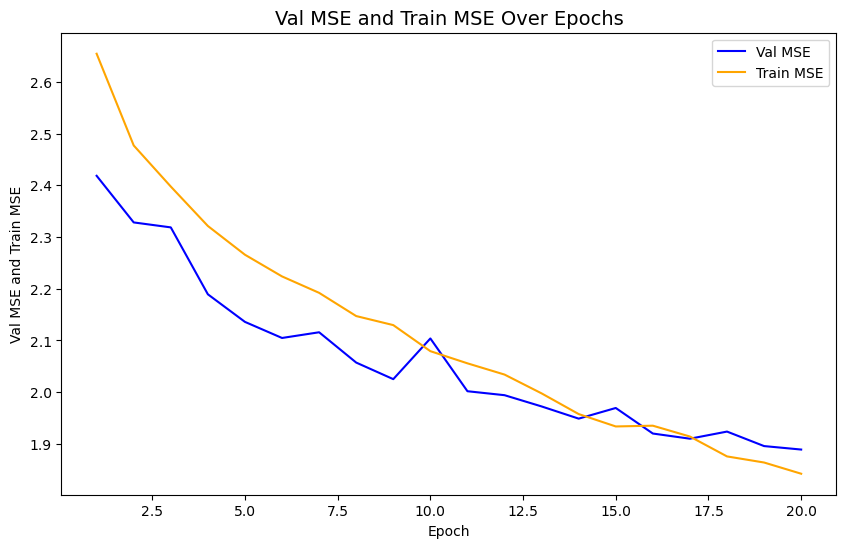

In [33]:
bench_mark_model.plot_train_history()